--- LAPORAN KESEHATAN DATA ---
Total Hari Kerja Seharusnya : 2609 hari
Total Data Tersedia         : 2423 hari
Jumlah Data Hilang          : 194 hari
Contoh Tanggal Hilang       : [Timestamp('2015-12-09 00:00:00'), Timestamp('2015-12-24 00:00:00'), Timestamp('2015-12-25 00:00:00'), Timestamp('2015-12-31 00:00:00'), Timestamp('2016-01-01 00:00:00')]

--- LAPORAN ANOMALI (VOLATILITAS) ---
Jumlah Hari dengan Pergerakan > 5% : 51 hari
Top 5 Pergerakan Paling Ekstrem:
             Close    Return
Date                        
2020-03-26  5975.0  0.183168
2020-03-27  6800.0  0.138075
2015-11-30  4875.0 -0.097222
2020-02-12  7000.0 -0.087948
2019-03-25  6775.0 -0.084459


C:\Users\user\AppData\Local\Temp\ipykernel_25428\3500660019.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Close'].pct_change() # Hitung % perubahan harian


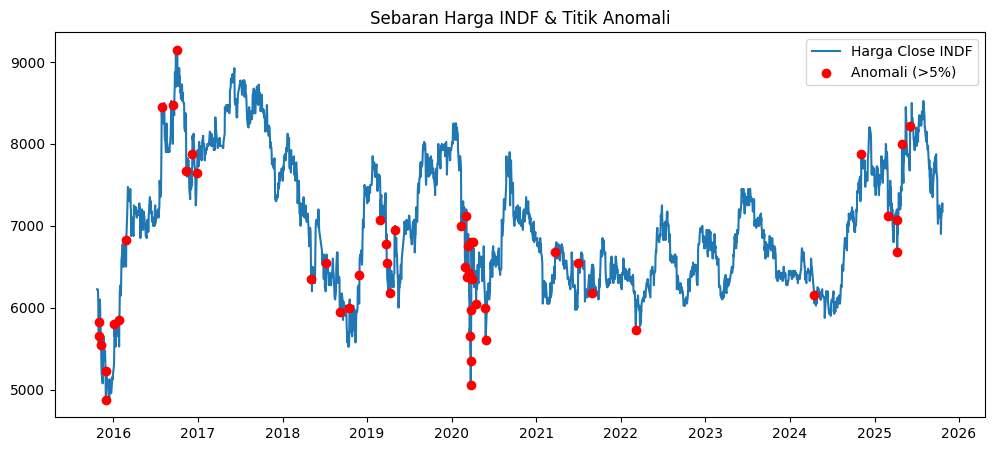

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. BACA DATA (Format Khusus: Pemisah titik koma & Ribuan titik)
df = pd.read_csv('Data Historis INDF.csv', sep=';', thousands='.')

# 2. GANTI NAMA KOLOM & FORMAT TANGGAL
df = df.rename(columns={'Tanggal': 'Date', 'Terakhir': 'Close'})
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.sort_values('Date').set_index('Date')

# 3. CEK MISSING VALUES (Hari Kerja yang Bolong)
all_business_days = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
missing_dates = all_business_days.difference(df.index)

print(f"--- LAPORAN KESEHATAN DATA ---")
print(f"Total Hari Kerja Seharusnya : {len(all_business_days)} hari")
print(f"Total Data Tersedia         : {len(df)} hari")
print(f"Jumlah Data Hilang          : {len(missing_dates)} hari")
print(f"Contoh Tanggal Hilang       : {missing_dates[:5].tolist()}")

# 4. CEK ANOMALI (Perubahan Harga Ekstrem > 5%)
df['Return'] = df['Close'].pct_change() # Hitung % perubahan harian
anomalies = df[abs(df['Return']) > 0.05] # Ambil yang perubahannya > 5%

print(f"\n--- LAPORAN ANOMALI (VOLATILITAS) ---")
print(f"Jumlah Hari dengan Pergerakan > 5% : {len(anomalies)} hari")
print("Top 5 Pergerakan Paling Ekstrem:")
print(anomalies[['Close', 'Return']].sort_values(by='Return', key=abs, ascending=False).head())

# 5. VISUALISASI SEDERHANA
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Close'], label='Harga Close INDF')
plt.scatter(anomalies.index, anomalies['Close'], color='red', label='Anomali (>5%)', zorder=5)
plt.title('Sebaran Harga INDF & Titik Anomali')
plt.legend()
plt.show()

In [2]:
import pandas as pd
import numpy as np

print("--- MEMULAI PERBAIKAN DATA (FINAL FIX) ---")

# 1. LOAD DATA ULANG (Pastikan start dari awal biar bersih)
df = pd.read_csv('Data Historis INDF.csv', sep=';', thousands='.')

# 2. STANDARDISASI KOLOM
df = df.rename(columns={'Tanggal': 'Date', 'Terakhir': 'Close'})
df = df[['Date', 'Close']] 

# 3. FORMAT TANGGAL & INDEX
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.sort_values('Date').set_index('Date')

# ========================================================
# LANGKAH PERBAIKAN ERROR (HAPUS TANGGAL GANDA)
# ========================================================
jumlah_duplikat = df.index.duplicated().sum()
if jumlah_duplikat > 0:
    print(f"⚠️ DITEMUKAN {jumlah_duplikat} TANGGAL GANDA! Sedang menghapus...")
    # Kita ambil data yang pertama muncul (keep='first') dan buang sisanya
    df = df[~df.index.duplicated(keep='first')]
    print("✅ Duplikat berhasil dihapus.")
else:
    print("✅ Tidak ada tanggal ganda. Aman.")

# ========================================================
# LANJUT KE REINDEXING & INTERPOLASI
# ========================================================

# 4. BUAT INDEX LENGKAP (BUSINESS DAYS)
all_business_days = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')

# 5. REINDEXING (Sekarang pasti berhasil karena duplikat sudah hilang)
df_clean = df.reindex(all_business_days)

# 6. INTERPOLASI LINEAR (Isi data libur)
df_clean['Close'] = df_clean['Close'].interpolate(method='linear', limit_direction='both')

# 7. PEMBULATAN
df_clean['Close'] = df_clean['Close'].round(0)

# ========================================================
# CEK HASIL & SIMPAN
# ========================================================
print(f"\n--- STATUS AKHIR ---")
print(f"Sisa Data Kosong : {df_clean['Close'].isnull().sum()} (Harus 0)")
print(f"Total Baris Data : {len(df_clean)}")

# Simpan
df_clean.to_csv('INDF_Cleaned.csv', index_label='Date')
print("\n🎉 SUKSES! File bersih tersimpan sebagai: 'INDF_Cleaned.csv'")

--- MEMULAI PERBAIKAN DATA (FINAL FIX) ---
⚠️ DITEMUKAN 7 TANGGAL GANDA! Sedang menghapus...
✅ Duplikat berhasil dihapus.

--- STATUS AKHIR ---
Sisa Data Kosong : 0 (Harus 0)
Total Baris Data : 2609

🎉 SUKSES! File bersih tersimpan sebagai: 'INDF_Cleaned.csv'


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Agar hasil eksperimen bisa direproduksi (adil)
tf.random.set_seed(42)
np.random.seed(42)

# Load data bersih
df = pd.read_csv('INDF_Cleaned.csv', parse_dates=['Date'], index_col='Date')
data_full = df[['Close']].values

# Parameter Tetap
WINDOW_SIZE = 30

# Fungsi untuk membuat window (seperti sebelumnya)
def create_window_dataset(dataset, lookback):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i-lookback:i])
        y.append(dataset[i])
    return np.array(X), np.array(y)

# ==========================================
# INTI: FUNGSI PEMBAGI SKENARIO
# ==========================================
def jalankan_skenario(ratio_train, ratio_val, ratio_test):
    print(f"\n>>> MENJALANKAN SKENARIO {int(ratio_train*100)}:{int(ratio_val*100)}:{int(ratio_test*100)} ...")
    
    n = len(data_full)
    n_train = int(ratio_train * n)
    n_val = int(ratio_val * n)
    # Sisanya buat test (biar total pas 100%)
    n_test = n - n_train - n_val 
    
    # 1. Splitting
    train_data = data_full[:n_train]
    val_data   = data_full[n_train:n_train+n_val]
    test_data  = data_full[-n_test:]
    
    # 2. Scaling (FIT HANYA DI TRAIN!)
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data)
    val_scaled   = scaler.transform(val_data)
    test_scaled  = scaler.transform(test_data)
    
    # 3. Windowing
    X_train, y_train = create_window_dataset(train_scaled, WINDOW_SIZE)
    X_val, y_val     = create_window_dataset(val_scaled, WINDOW_SIZE)
    X_test, y_test   = create_window_dataset(test_scaled, WINDOW_SIZE)
    
    print(f"   Shape Train: {X_train.shape}")
    print(f"   Shape Val  : {X_val.shape}")
    print(f"   Shape Test : {X_test.shape}")
    
    # KEMBALIKAN DATA YANG SUDAH SIAP
    return {
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test,
        'scaler': scaler # Scaler butuh disimpan buat invers nanti
    }

# ==========================================
# EKSEKUSI 3 SKENARIO
# ==========================================
# List skenario: (Train, Val, Test)
skenario_list = [
    (0.80, 0.10, 0.10),
    (0.70, 0.15, 0.15),
    (0.60, 0.20, 0.20)
]

# Dictionary untuk menyimpan semua data siap pakai
datasets = {}

for r_train, r_val, r_test in skenario_list:
    nama_skenario = f"{int(r_train*100)}-{int(r_val*100)}-{int(r_test*100)}"
    
    # Panggil fungsi di atas
    datasets[nama_skenario] = jalankan_skenario(r_train, r_val, r_test)

print("\n✅ SEMUA SKENARIO SUDAH DIPROSES & DISIMPAN!")
print("Cara akses data: datasets['80-10-10']['X_train']")

d:\Kuliah\Semester7\PraTA\env_ta\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):



>>> MENJALANKAN SKENARIO 80:10:10 ...
   Shape Train: (2057, 30, 1)
   Shape Val  : (230, 30, 1)
   Shape Test : (232, 30, 1)

>>> MENJALANKAN SKENARIO 70:15:15 ...
   Shape Train: (1796, 30, 1)
   Shape Val  : (361, 30, 1)
   Shape Test : (362, 30, 1)

>>> MENJALANKAN SKENARIO 60:20:20 ...
   Shape Train: (1535, 30, 1)
   Shape Val  : (491, 30, 1)
   Shape Test : (493, 30, 1)

✅ SEMUA SKENARIO SUDAH DIPROSES & DISIMPAN!
Cara akses data: datasets['80-10-10']['X_train']


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. FUNGSI BANGUN MODEL (Sederhana: 1 Layer CNN + 1 Layer BiLSTM)
def build_simple_hybrid_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        
        # HANYA 1 LAYER CNN
        # [cite_start]filters=32 sesuai rekomendasi awal di jurnal untuk ekstraksi fitur utama [cite: 354, 384]
        Conv1D(filters=32, kernel_size=3, activation='relu'), 
        MaxPooling1D(pool_size=2), # Menghilangkan noise dan mereduksi dimensi
        
        # HANYA 1 LAYER BiLSTM
        # [cite_start]units=50 atau 64 adalah titik tengah yang stabil [cite: 354, 384]
        Bidirectional(LSTM(units=50, return_sequences=False)), 
        
        Dropout(0.2), # Menjaga agar model tetap general (tidak kaku)
        
        # Langsung ke Dense Layer
        Dense(units=16, activation='relu'),
        Dense(units=1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# 2. PROSES TRAINING OTOMATIS (MENGGUNAKAN LOOP DATASETS SEBELUMNYA)
results_simple = {}

for nama, ds in datasets.items():
    print(f"\n--- TRAINING SKENARIO {nama} (VERSION: 1-LAYER) ---")
    
    input_shape = (ds['X_train'].shape[1], ds['X_train'].shape[2])
    model = build_simple_hybrid_model(input_shape)
    
    # [cite_start]Gunakan Early Stopping agar model berhenti di titik paling optimal [cite: 337]
    callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(
        ds['X_train'], ds['y_train'],
        validation_data=(ds['X_val'], ds['y_val']),
        epochs=100, 
        batch_size=100, 
        callbacks=[callback],
        verbose=1
    )
    
    results_simple[nama] = {
        'model': model,
        'history': history.history
    }

print("\n✅ TRAINING 1-LAYER SELESAI!")


--- TRAINING SKENARIO 80-10-10 (VERSION: 1-LAYER) ---
Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0654 - val_loss: 0.0027
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0105 - val_loss: 0.0050
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0080 - val_loss: 0.0030
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0067 - val_loss: 0.0017
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0059 - val_loss: 0.0016
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0053 - val_loss: 0.0015
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0051 - val_loss: 0.0012
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038 - val_loss: 0.0010
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - val_loss: 8.0783e-04
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - val_loss: 


--- Mengevaluasi Skenario 80-10-10 ---


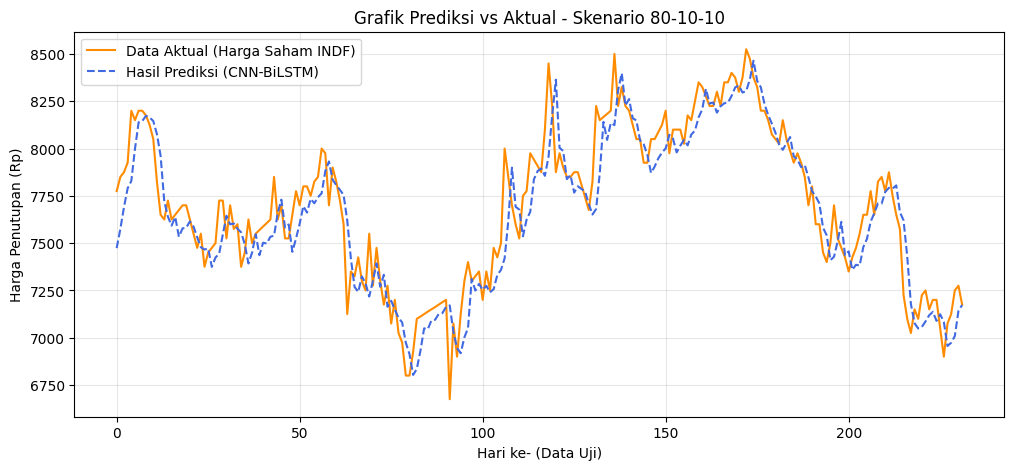


--- Mengevaluasi Skenario 70-15-15 ---


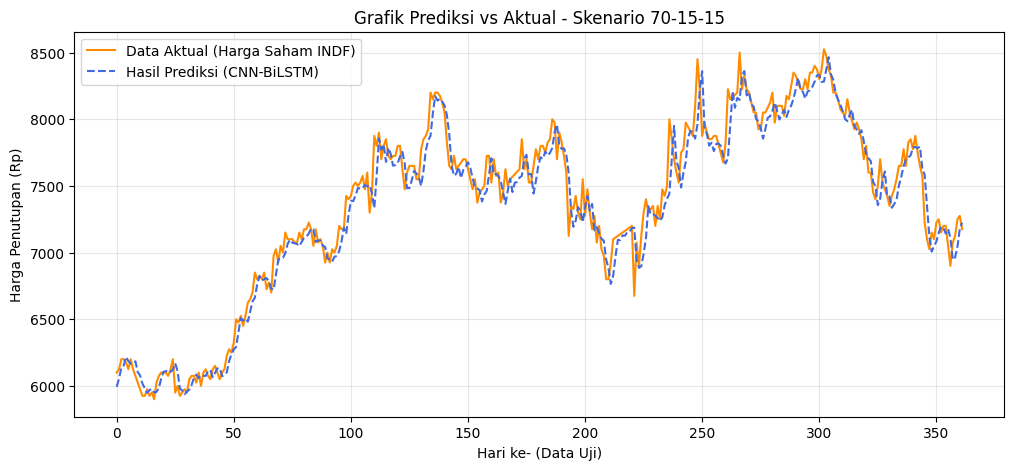


--- Mengevaluasi Skenario 60-20-20 ---


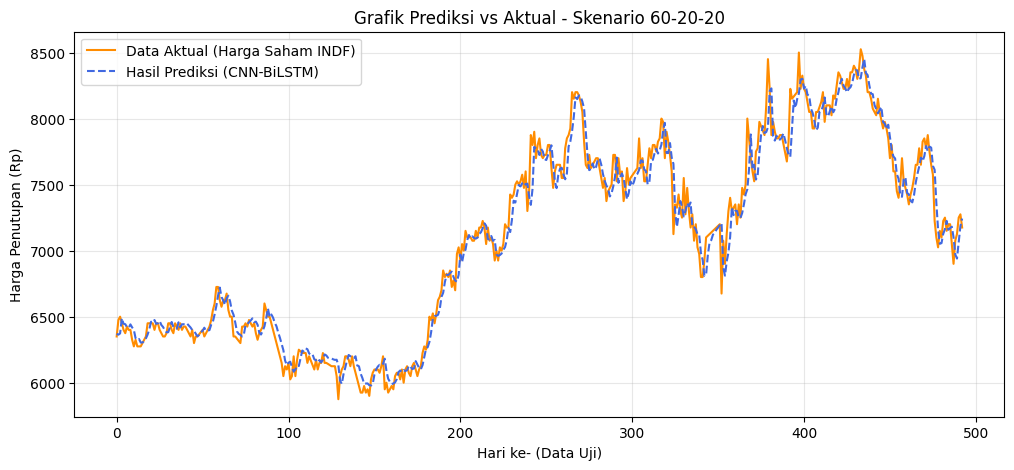


TABEL REKAPITULASI PERFORMA MODEL CNN-BiLSTM


,Skenario (Train:Val:Test),RMSE (Rupiah),MAE (Rupiah),MAPE (%),R-Squared (R2),Kategori Akurasi
0,80:10:10,158.32,118.71,1.55,0.8441,Sangat Akurat
1,70:15:15,134.47,97.10,1.31,0.9597,Sangat Akurat
2,60:20:20,120.29,86.53,1.20,0.9732,Sangat Akurat


In [10]:
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==========================================
# 1. FUNGSI EVALUASI LENGKAP (SESUAI PROPOSAL & JURNAL)
# ==========================================
def hitung_metrik(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    # Penentuan Kategori MAPE berdasarkan Skala Lewis (Mushliha, 2024)
    if mape < 10:
        kategori = "Sangat Akurat"
    elif 10 <= mape < 20:
        kategori = "Baik"
    elif 20 <= mape < 50:
        kategori = "Normal"
    else:
        kategori = "Tidak Akurat"
        
    return rmse, mae, mape, r2, kategori

# ==========================================
# 2. PROSES EVALUASI UNTUK SEMUA SKENARIO
# ==========================================
rekap_hasil = []

for nama, ds in datasets.items():
    print(f"\n--- Mengevaluasi Skenario {nama} ---")
    
    # Ambil model terbaik dari hasil training sebelumnya
    model = results_simple[nama]['model']
    scaler = ds['scaler']
    
    # a. Prediksi pada Data Uji (Test Set)
    y_pred_scaled = model.predict(ds['X_test'], verbose=0)
    
    # b. Invers Scaling (Kembalikan angka 0-1 ke Harga Rupiah Asli)
    y_test_asli = scaler.inverse_transform(ds['y_test'].reshape(-1, 1))
    y_pred_asli = scaler.inverse_transform(y_pred_scaled)
    
    # c. Hitung Semua Metrik (MAE, RMSE, MAPE, R2)
    rmse, mae, mape, r2, kat = hitung_metrik(y_test_asli, y_pred_asli)
    
    # Simpan ke daftar rekap
    rekap_hasil.append({
        'Skenario (Train:Val:Test)': nama.replace('-', ':'),
        'RMSE': round(rmse, 2),
        'MAE': round(mae, 2),
        'MAPE (%)': round(mape, 2),
        'R-Squared': round(r2, 4),
        'Kategori': kat
    })
    
    # d. Visualisasi Grafik Perbandingan (Sesuai Bab 3 Metodologi)
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_asli, label='Data Aktual (Harga Saham INDF)', color='darkorange', linewidth=1.5)
    plt.plot(y_pred_asli, label='Hasil Prediksi (CNN-BiLSTM)', color='royalblue', linestyle='--', linewidth=1.5)
    plt.title(f'Grafik Prediksi vs Aktual - Skenario {nama}')
    plt.xlabel('Hari ke- (Data Uji)')
    plt.ylabel('Harga Penutupan (Rp)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ==========================================
# 3. TAMPILKAN TABEL HASIL AKHIR (UNTUK BAB 4 TA)
# ==========================================
# Membuat DataFrame dari list rekap_hasil yang sudah kita kumpulkan tadi
df_hasil_akhir = pd.DataFrame(rekap_hasil)

# Mengatur tampilan kolom agar lebih rapi
df_hasil_akhir.columns = [
    'Skenario (Train:Val:Test)', 
    'RMSE (Rupiah)', 
    'MAE (Rupiah)', 
    'MAPE (%)', 
    'R-Squared (R2)', 
    'Kategori Akurasi'
]

# Menampilkan tabel
print("\n" + "="*80)
print("TABEL REKAPITULASI PERFORMA MODEL CNN-BiLSTM")
print("="*80)
display(df_hasil_akhir) # Menggunakan display agar tampilan di Notebook lebih cantik
print("="*80)

# (Opsional) Simpan tabel ke Excel jika Anda ingin memasukkannya ke lampiran TA
# df_hasil_akhir.to_excel('Hasil_Eksperimen_Skenario.xlsx', index=False)